# Assignment 1
#### Name: Immanuel Ponminissery
#### UT EID: ijp284

# S&P 500

In [1]:
#importing required packages
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [2]:
#importing raw file from WRDS and computing Market Cap and other adjustments
df = pd.read_csv('hw1_v4.csv')
df['date']=df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['Market Cap'] = abs(df['PRC'])*df['SHROUT']
df['Adjusted prices'] = df['PRC']/df['CFACPR']
df['Adjusted shares'] = df['SHROUT']*df['CFACSHR']
#taking only common stock
df_only_stock = df[(df['SHRCD']==11) | (df['SHRCD']==10)].copy()

In [3]:
#function for finding end of year rows
def is_end_of_year(date):
    if date.month == 12:
        return True
    else:
        return False

In [4]:
# reconstitute contains the companys that will be used for each year
mask = df_only_stock['date'].map(is_end_of_year)
only_end_of_year = df_only_stock[mask].copy()
only_end_of_year_sorted = only_end_of_year.sort_values(['date','Market Cap'],ascending=False).copy()
reconstitute = only_end_of_year_sorted.groupby('date').head(505)
reconstitute['year'] = reconstitute['date'].dt.year
reconstitute = reconstitute.drop_duplicates(subset=['date', 'PERMNO'], keep='last')

C:\Users\ImmanuelJP\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
#I am also just cleaning up the data set here and adding columns
#year, quarter and month so that things are easier later
df_only_stock['year'] = df_only_stock['date'].dt.year
df_only_stock['quarter'] = df_only_stock['date'].dt.quarter
df_only_stock['month'] = df_only_stock['date'].dt.month
df_only_stock = df_only_stock.drop_duplicates(subset=['date', 'PERMNO'], keep='last')

In [6]:
#Here I am initializing the required parameters to go through the loop that
#will show up soon
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
quarters = [1,2,3,4]
insert = pd.DataFrame()

In [7]:
#The loop below computes temporary weights for every quarter and then merges it
#to a dataframe every month. This data frame is then appended to the blank 
#dataframe created in the previous step.
c = list(df_only_stock.columns)
c.append('weights')
for year in years:#going over every year
    list_of_companies = reconstitute[reconstitute['year'] == year-1][['PERMNO','TICKER','COMNAM']]
    for quarter in quarters:#going over every quarter. The if statement below assigns weights based on quarter.
        if quarter == 1:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 4) & (df_only_stock['year'] == year-1) & (df_only_stock['month'] == 12)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Market Cap']/temp_weights['Market Cap'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 1) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'PERMNO', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)
        elif quarter == 2:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 1) & (df_only_stock['year'] == year) & (df_only_stock['month'] == 3)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Market Cap']/temp_weights['Market Cap'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 2) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'PERMNO', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)
        elif quarter == 3:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 2) & (df_only_stock['year'] == year) & (df_only_stock['month'] == 6)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Market Cap']/temp_weights['Market Cap'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 3) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'PERMNO', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)
        else:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 3) & (df_only_stock['year'] == year) & (df_only_stock['month'] == 9)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Market Cap']/temp_weights['Market Cap'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 4) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'PERMNO', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)

In [8]:
insert = insert.dropna(subset = ['Market Cap'])
insert['pre'] = insert['Market Cap']*insert['weights']
returns = insert.groupby('date').agg(sum)

In [9]:
#A divisor is computed here. This divisor is proprietary information for S&P 500
#so my team estimated it by finding the sum of weights * market caps for two different years and 
# dividing it by the proce of S&P at the beginning of the year and dividing it by 12
divisor = ((returns[returns.index.year==2010]['pre'].sum())/1115.10/12 + (returns[returns.index.year==2019]['pre'].sum())/3230.78/12)/2

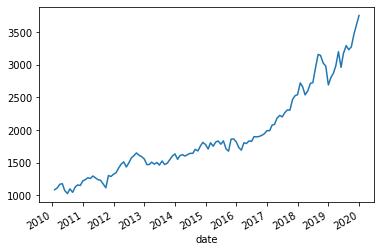

In [10]:
(returns['pre']/divisor).plot()

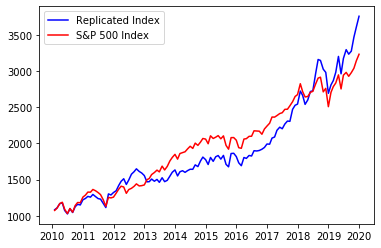

In [11]:
#This section is to find comparisons
s_p_500 = pd.read_csv('s_p_500_new.csv')
s_p_500 = list(s_p_500['spindx'])[1:]

spy = pd.read_csv('spy.csv')
spy = list(spy['PRC'])[1:]

vfinx = pd.read_csv('VFINX (1).csv')
vfinx = list(vfinx['Adj Close'][1:])

my_index = list((returns['pre']/divisor))
dates = list(returns.index)

plt.plot_date(md.date2num(dates),my_index,'b-', label = 'Replicated Index')
plt.plot_date(md.date2num(dates),s_p_500,'r-', label = 'S&P 500 Index')
plt.legend()

In [12]:
#finding returns
price_df = pd.DataFrame(list(zip(my_index,s_p_500,spy,vfinx)), index = dates, columns = ['my_index','s_p_500','spy','vfinx'])
price_df['my_index_return'] = (price_df['my_index']/price_df['my_index'].shift(1) - 1)
price_df['s_p_500_return'] = (price_df['s_p_500']/price_df['s_p_500'].shift(1) - 1)
price_df['spy_return'] = (price_df['spy']/price_df['spy'].shift(1) - 1)
price_df['vfinx_return'] = (price_df['vfinx']/price_df['vfinx'].shift(1) - 1)

In [13]:
def value_stats(l):
    print('Expected annual return of {} is {} and standard deviation is {}'.format(l.name,(1+l.mean())**12-1, l.std()*12**0.5))

value_stats(price_df['my_index_return'])
value_stats(price_df['s_p_500_return'])
value_stats(price_df['spy_return'])
value_stats(price_df['vfinx_return'])

Expected annual return of my_index_return is 0.1446576477363959 and standard deviation is 0.14197653448538058
Expected annual return of s_p_500_return is 0.12598191440210105 and standard deviation is 0.12422438227554362
Expected annual return of spy_return is 0.12558197473851385 and standard deviation is 0.12446954345004461
Expected annual return of vfinx_return is 0.14475775787770906 and standard deviation is 0.1265914121011978


# Dow Jones

This code is similar to the S&P 500 so please refer to the code above for more info regarding code if there are any doubts.

In [14]:
#List of tickers and years that they were part of the index
reconstitute = pd.read_csv('dj_companies.csv')
reconstitute

,year,TICKER
0,2009,MMM
1,2009,AXP
2,2009,BA
3,2009,CAT
4,2009,CVX
...,...,...
295,2018,GS
296,2018,V
297,2018,AAPL
298,2018,DWDP


In [15]:
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
quarters = [1,2,3,4]
insert = pd.DataFrame()

In [16]:
c = list(df_only_stock.columns)
c.append('weights') #The weights have been adjusted to reflect price weighted nature
for year in years:
    list_of_companies = reconstitute[reconstitute['year'] == year-1][['TICKER']]
    for quarter in quarters:
        if quarter == 1:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 4) & (df_only_stock['year'] == year-1) & (df_only_stock['month'] == 12)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Adjusted prices']/temp_weights['Adjusted prices'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 1) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'TICKER', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)
        elif quarter == 2:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 1) & (df_only_stock['year'] == year) & (df_only_stock['month'] == 3)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Adjusted prices']/temp_weights['Adjusted prices'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 2) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'TICKER', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)
        elif quarter == 3:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 2) & (df_only_stock['year'] == year) & (df_only_stock['month'] == 6)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Adjusted prices']/temp_weights['Adjusted prices'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 3) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'TICKER', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)
        else:
            temp_weights = df_only_stock[(df_only_stock['quarter'] == 3) & (df_only_stock['year'] == year) & (df_only_stock['month'] == 9)].merge(list_of_companies, how = 'inner')
            temp_weights['weights'] = temp_weights['Adjusted prices']/temp_weights['Adjusted prices'].sum()
            temp_monthly = df_only_stock[(df_only_stock['quarter'] == 4) & (df_only_stock['year'] == year)].merge(temp_weights, how = 'inner', on = 'TICKER', suffixes= (None, '_y'))
            insert = insert.append(temp_monthly[c],ignore_index = True)

In [17]:
insert['pre'] = insert['Adjusted prices']*insert['weights']
returns = insert.groupby('date').agg(sum)

In [18]:
divisor = ((12*8772.25)/(returns[returns.index.year==2010]['pre'].sum()) + (12*28538.44)/(returns[returns.index.year==2019]['pre'].sum()))/2

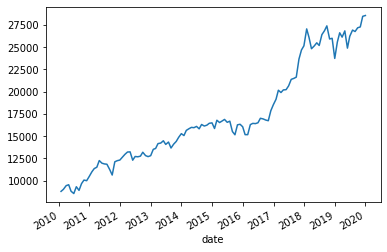

In [19]:
(returns['pre']*divisor).plot()

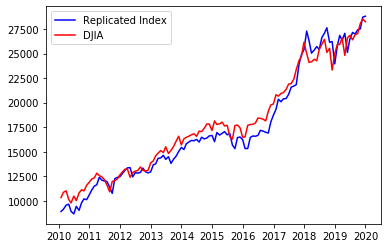

In [20]:
djia = pd.read_csv('^DJI (2).csv')
djia = list(djia['Adj Close'])[1:]

dia = pd.read_csv('DIA.csv')
dia = list(dia['Adj Close'])[1:]

rydax = pd.read_csv('RYDAX.csv')
rydax = list(rydax['Adj Close'][1:])
rydax = [np.nan]*72+rydax #For RYDAX, values for all the years could not be found.
#So, I put an np.nan in there

my_index = list((returns['pre']*157.9))
dates = list(returns.index)

plt.plot_date(md.date2num(dates),my_index,'b-', label = 'Replicated Index')
plt.plot_date(md.date2num(dates),djia,'r-', label = 'DJIA')
plt.legend()

In [21]:
price_df = pd.DataFrame(list(zip(my_index,djia,dia,rydax)), index = dates, columns = ['my_index','djia','dia','rydax'])
price_df['my_index_return'] = (price_df['my_index']/price_df['my_index'].shift(1) - 1)
price_df['djia_return'] = (price_df['djia']/price_df['djia'].shift(1) - 1)
price_df['dia_return'] = (price_df['dia']/price_df['dia'].shift(1) - 1)
price_df['rydax_return'] = (price_df['rydax']/price_df['rydax'].shift(1) - 1)

In [22]:
def value_stats(l):
    print('Expected annual return of {} is {} and standard deviation is {}'.format(l.name,(1+l.mean())**12-1, l.std()*12**0.5))
value_stats(price_df['my_index_return'])
value_stats(price_df['djia_return'])
value_stats(price_df['dia_return'])
value_stats(price_df['rydax_return'])

Expected annual return of my_index_return is 0.13516058837456502 and standard deviation is 0.1308774572765402
Expected annual return of djia_return is 0.11476296730767865 and standard deviation is 0.12041687122765767
Expected annual return of dia_return is 0.1413722126570136 and standard deviation is 0.12132931061566224
Expected annual return of rydax_return is 0.16450857922895334 and standard deviation is 0.12643698630753786
